In [ ]:
from utils import names

files = names.get_file_names()
models = names.get_model_names()

# Prediction

In [2]:
SRT_CORRECTION_SYSTEM_PROMPT = """
Sei un correttore professionista di sottotitoli, specializzato in contenuti multimediali in {language}.

Riceverai una singola frase di sottotitolo relativa a un segmento video prodotto da RCS MediaGroup (es. giornalismo, interviste, sport, ecc.).

Questa frase è stata generata automaticamente con Whisper e può contenere errori di battitura, formattazione, o trascrizione del parlato.

Il tuo compito è correggere gli errori evidenti come:
- Refusi e errori ortografici
- Nomi propri o di luoghi mal trascritti
- Errori grammaticali o sintattici minori

Non alterare la struttura o i contenuti che risultano corretti.

**IMPORTANTE**: restituisci esclusivamente la frase corretta, senza spiegazioni, note o testo aggiuntivo.

Frase da correggere:
"""

In [ ]:
from google import genai
from google.genai import types
import time

client = genai.Client(
    api_key="GOOGLE_API_KEY"
)


def correct_single_subtitle(subtitle_text, language='italiano', max_retries=3):
    """
    Invia una singola frase di sottotitolo al modello per la correzione.
    Restituisce il testo corretto o quello originale in caso di errore.
    """
    if not subtitle_text or not subtitle_text.strip():
        return subtitle_text

    original_text = subtitle_text.strip()
    
    # Costruisci il prompt completo
    system_prompt = SRT_CORRECTION_SYSTEM_PROMPT.format(language=language)
    full_prompt = system_prompt + original_text

    contents = [
        types.Content(
            role='user',
            parts=[types.Part.from_text(text=full_prompt)]
        )
    ]

    retry = 0
    while retry < max_retries:
        try:
            response = client.models.generate_content(
                model="gemma-3-12b-it",
                contents=contents,
                config=types.GenerateContentConfig(
                    temperature=0
                )
            )
            
            corrected_text = response.text.strip()
            
            # Rimuovi eventuali markdown o formattazioni extra
            if corrected_text.startswith('```'):
                lines = corrected_text.split('\n')
                corrected_text = '\n'.join(lines[1:-1]) if len(lines) > 2 else corrected_text
            
            # Se la risposta è vuota o troppo diversa (possibile allucinazione), usa l'originale
            if not corrected_text or len(corrected_text) > len(original_text) * 2:
                print(f"Risposta sospetta per '{original_text[:50]}...': '{corrected_text[:50]}...'. Uso originale.")
                return original_text
            
            return corrected_text

        except Exception as e:
            print(f"Errore durante la correzione (tentativo {retry + 1}/{max_retries}): {e}")
            retry += 1
            time.sleep(1)  # Attendi un secondo prima di riprovare

    print(f"Max retries raggiunti per '{original_text[:50]}...'. Mantengo testo originale.")
    return original_text

In [ ]:
from standardization import standardization_utils
import os

def convert_ms_to_str(ms: int):
    h = ms // 3600000
    ms = ms % 3600000
    m = ms // 60000
    ms = ms % 60000
    s = ms // 1000
    ms = ms % 1000
    return f"{h:02}:{m:02}:{s:02},{ms:03}"

# Crea la directory di output se non esiste
os.makedirs("../data/whisperx/reviewer_agent_gemma/srt", exist_ok=True)
os.makedirs("../data/whisperx/reviewer_agent_gemma/txt", exist_ok=True)

for file_name in files:
    print(f"Elaborating file {file_name}...")
    input_path = f"../data/whisperx/srt/{file_name}.srt"
    output_srt_path = f"../data/whisperx/reviewer_agent_gemma/srt/{file_name}.srt"

    # Leggi sottotitoli originali
    try:
        with open(input_path, 'r', encoding='utf-8') as f:
            srt_content = f.read()
            original_subtitles = standardization_utils.preprocess(srt_content)
    except FileNotFoundError:
        print(f"File di input non trovato: {input_path}. Salto.")
        continue

    # Elabora e salva in modo incrementale
    with open(output_srt_path, "w", encoding="utf-8") as f_out:
        for idx, sub in enumerate(original_subtitles, start=1):
            print(f"  Correggendo sottotitolo {idx}/{len(original_subtitles)}: '{sub.text[:50]}...'")
            
            # Ottieni la correzione per il singolo sottotitolo
            corrected_text = correct_single_subtitle(sub.text, language='italiano')
            
            # Scrivi immediatamente il sottotitolo corretto nel file di output
            f_out.write(f"{idx}\n")
            f_out.write(f"{convert_ms_to_str(sub.start_time)} --> {convert_ms_to_str(sub.end_time)}\n")
            f_out.write(f"{corrected_text}\n\n")
            
            # Flush per assicurarsi che venga scritto immediatamente
            f_out.flush()
            
    print(f"File {file_name} elaborato e salvato in {output_srt_path}")
    print(f"Sottotitoli processati: {len(original_subtitles)}")
    print("-" * 50)

## Computation of the matching entities

In [ ]:
import pandas as pd

df_spacy = pd.read_excel("spacy_all_matched_entities.xlsx")

In [ ]:
from metrics import spacy_eer_pipeline

models.append("whisperx/reviewer_agent_gemma")

df_spacy_1 = spacy_eer_pipeline.compare_multiple_asr(files, models, threshold=0.85, time_pad=5)

In [10]:
df_spacy_1.shape[0]

13953

In [9]:
# mantieni in df_spacy_1 solo le righe che ci sono anche in df_spacy
df_spacy_1 = df_spacy_1[df_spacy_1['gt_entity'].isin(df_spacy['gt_entity'].unique())]

In [ ]:
import pandas as pd

# 1. Normalizzazione
df_spacy['gt_norm'] = df_spacy['gt_entity'].astype(str).apply(spacy_eer_pipeline.clean_entity_text)
df_spacy_1['gt_norm'] = df_spacy_1['gt_entity'].astype(str).apply(spacy_eer_pipeline.clean_entity_text)

# 2. Definizione della chiave
key_cols = ['program', 'gt_norm']

# 3. Deduplicazione di df_spacy_1
df_spacy_1_unique = df_spacy_1.drop_duplicates(subset=key_cols)

# 4. Merge
df_spacy_1_aligned = pd.merge(
    df_spacy,
    df_spacy_1_unique[['whisperx/reviewer_agent_gemma'] + key_cols],
    on=key_cols,
    how='left'
)

# Sostituisci il vecchio df_spacy_1 con la versione allineata
df_spacy_1 = df_spacy_1_aligned.copy()

# Rimuovi la colonna di normalizzazione se non più necessaria
df_spacy_1 = df_spacy_1.drop(columns=['gt_norm'])
df_spacy = df_spacy.drop(columns=['gt_norm'])


print(f"Shape di df_spacy: {df_spacy.shape}")
print(f"Shape di df_spacy_1 dopo l'allineamento: {df_spacy_1.shape}")


Shape di df_spacy: (13463, 11)
Shape di df_spacy_1 dopo l'allineamento: (13463, 12)


In [12]:
df_spacy_1[['program', 'gt_entity', 'whisperx', 'whisperx/reviewer_agent_gemma']].to_excel("reviewer_agent_gemma12b.xlsx", index=False, engine='openpyxl')

## Computation of EER

In [13]:
import pandas as pd

df_reviewer = pd.read_excel("reviewer_agent_gemma12b.xlsx")

In [ ]:
def compute_entity_error_rate(df):    
    asr_models = ["whisperx","whisperx/reviewer_agent_gemma"]
    error_dict = {}

    for program, subdf in df.groupby("program"):
        error_dict[program] = {}
        for model in asr_models:
            total = len(subdf)
            errors = 0
            for _, row in subdf.iterrows():
                gt = spacy_eer_pipeline.clean_entity_text(str(row["gt_entity"]).strip().lower())                
                asr = spacy_eer_pipeline.clean_entity_text(str(row[model]).strip().lower())                
                if gt != asr:                    
                    errors += 1                    
            error_rate = round(errors / total, 3)if total else 0
            error_dict[program][model] = error_rate

    # Crea il DataFrame con programmi come righe e modelli come colonne
    error_df = pd.DataFrame.from_dict(error_dict, orient="index", columns=asr_models)
    return error_df

In [15]:
new_eer_results = compute_entity_error_rate(df_reviewer)

In [16]:
new_eer_results['whisperx/before'] = new_eer_results["whisperx"]

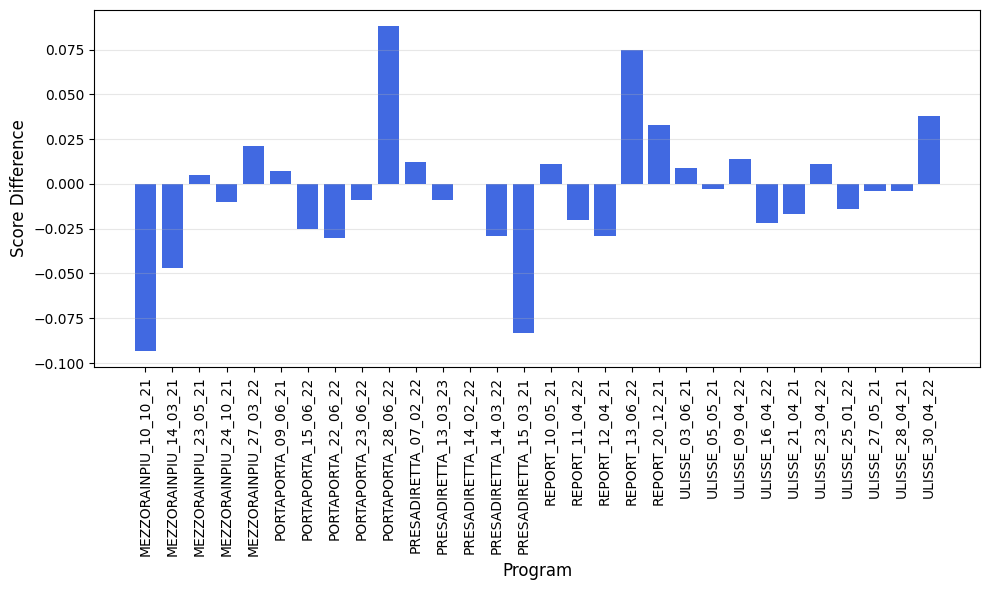

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Calcola la differenza tra dopo (con reviewer) e prima (senza reviewer)
diff = new_eer_results["whisperx/reviewer_agent_gemma"] - new_eer_results["whisperx/before"]

# Grafico a barre
plt.bar(new_eer_results.index, diff, color="royalblue")

#plt.title("EER: WhisperX With Reviewer (After - Before)", fontsize=14)
plt.xlabel("Program", fontsize=12)
plt.ylabel("Score Difference", fontsize=12)
plt.xticks(rotation=90)

plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


In [19]:
# Calcola il miglioramento per ogni file
new_eer_results['improvement'] = new_eer_results['whisperx/before'] - new_eer_results['whisperx/reviewer_agent_gemma']

# 1. Calcola e stampa il miglioramento medio complessivo
average_improvement = new_eer_results['improvement'].mean()
print(f"Miglioramento medio complessivo: {average_improvement:.3f}")

# 2. Stampa in quanti file c'è stato un miglioramento o peggioramento
improvements_count = (new_eer_results['improvement'] > 0).sum()
worsenings_count = (new_eer_results['improvement'] < 0).sum()
print(f"Numero di file con miglioramento: {improvements_count}")
print(f"Numero di file con peggioramento: {worsenings_count}")

# 3. Stampa il miglioramento medio per programma
# Estrai il nome del programma dall'indice
new_eer_results['program_name'] = new_eer_results.index.str.extract(r'([A-Z_]+)')
improvement_by_program = new_eer_results.groupby('program_name')['improvement'].mean()

print("\nMiglioramento medio per programma:")
print(improvement_by_program)

Miglioramento medio complessivo: 0.004
Numero di file con miglioramento: 17
Numero di file con peggioramento: 12

Miglioramento medio per programma:
Series([], Name: improvement, dtype: float64)


In [20]:
from scipy import stats

before = new_eer_results['whisperx/before'].to_list()
after = new_eer_results['whisperx/reviewer_agent_gemma'].to_list()

t_stat, p_value = stats.ttest_rel(before, after)
print("t-statistic:", t_stat)
print("p-value:", p_value)

t-statistic: 0.615819189026135
p-value: 0.542817409834511
